### Get Data

In [ ]:
!git clone https://github.com/Saatwik-M/Self-Driving-Car

fatal: destination path 'Self-Driving-Car' already exists and is not an empty directory.


In [ ]:
!ls Self-Driving-Car

driving_log.csv  IMG  sdc_1.h5	selfdc.py


### Imports

In [ ]:
from imgaug import augmenters as iaa
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random

Using TensorFlow backend.


### Basic Data Formatting and Processing

In [ ]:
datadir = 'Self-Driving-Car'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data  = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

center  ...     speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

In [ ]:
def pathsplit(path):
    head, tail = ntpath.split(path)
    return tail

In [ ]:
data['center'] = data['center'].apply(pathsplit)
data['left'] = data['left'].apply(pathsplit)
data['right'] = data['right'].apply(pathsplit)

In [ ]:
data.head()

center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

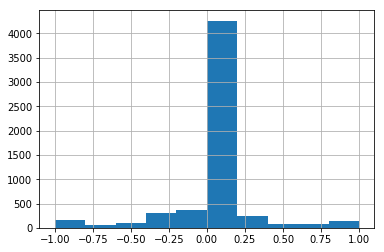

In [ ]:
data['steering'].hist()

In [ ]:
len(data[data['steering'] == 0])

3832

In [ ]:
print('before:', len(data))
list_ = []
for i in range(len(data['steering'])):
    if data['steering'][i] == 0:
        list_.append(i)
list_ = shuffle(list_)
remove_list = list_[1000:]

data.drop(data.index[remove_list], inplace = True)

print('after:', len(data))

before: 5821
after: 2989


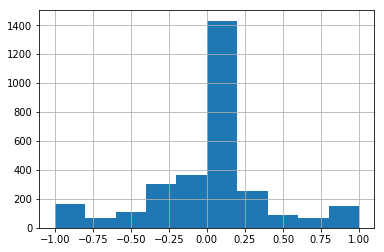

In [ ]:
data['steering'].hist()

In [ ]:
def loadimgstr(datadir, df):
    image_path = []
    steering = []
    for i in range(len(df)):
        #Center Images
        image_path.append(os.path.join(datadir, df.iloc[i][0]))
        steering.append(float(df.iloc[i][3]))
        #Left Images
        image_path.append(os.path.join(datadir, df.iloc[i][1]))
        steering.append(float(df.iloc[i][3] + 0.15))
        #Right Images
        image_path.append(os.path.join(datadir, df.iloc[i][2]))
        steering.append(float(df.iloc[i][3] - 0.15))
        
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steering

In [ ]:
image_paths, steerings = loadimgstr(datadir + '/IMG', data)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 7173
Valid Samples: 1794


Text(0.5, 1.0, 'Validation set')

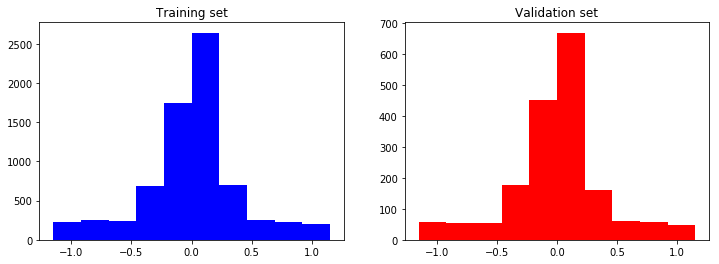

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, color='red')
axes[1].set_title('Validation set')

### Data Augmentation

In [ ]:
def zoom(image):    
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

def pan(image):
    pan = iaa.Affine(translate_percent= {"y": (-0.15, 0.15)})
    image = pan.augment_image(image)
    return image

def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

def img_contrast(image):
    contrast = iaa.ContrastNormalization((0.75, 1.25))
    image = contrast.augment_image(image)
    return image

def img_channel_shift(image):
    channel_shift = aug = iaa.Add((-40, 40), per_channel=True)
    image = channel_shift.augment_image(image)
    return image

def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_contrast(image)
    if np.random.rand() < 0.5:
        image = img_channel_shift(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)
    return image, steering_angle

def img_preprocess(img):
    img = img[50:145,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

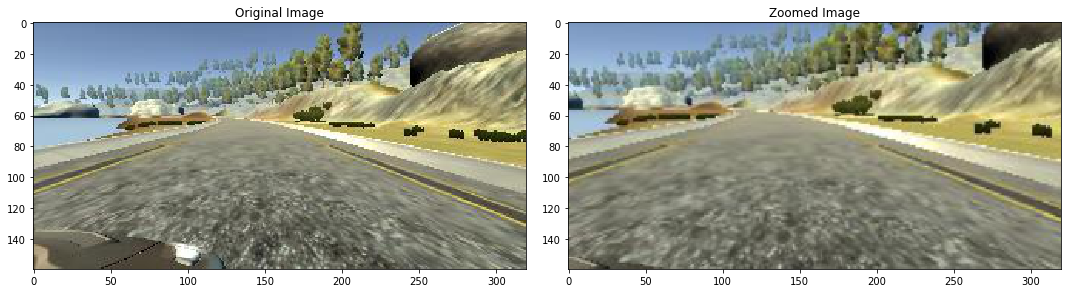

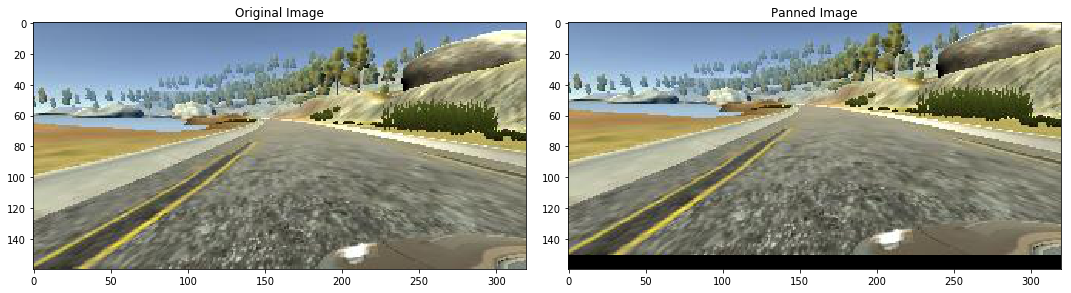

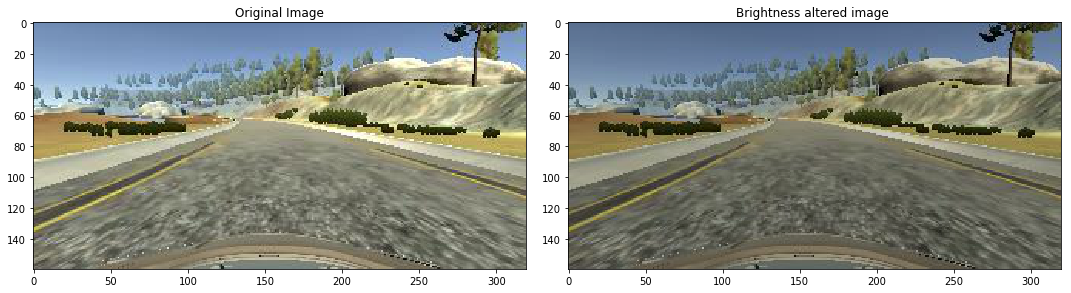

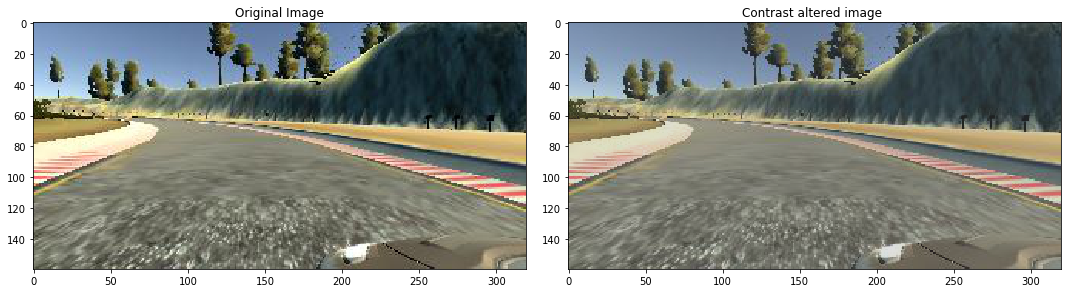

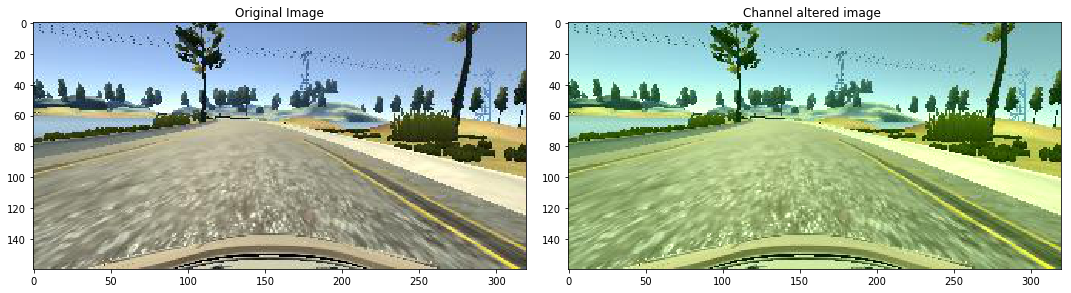

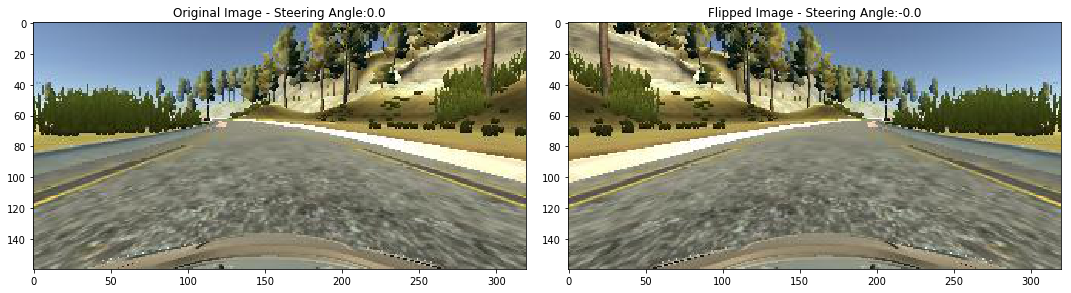

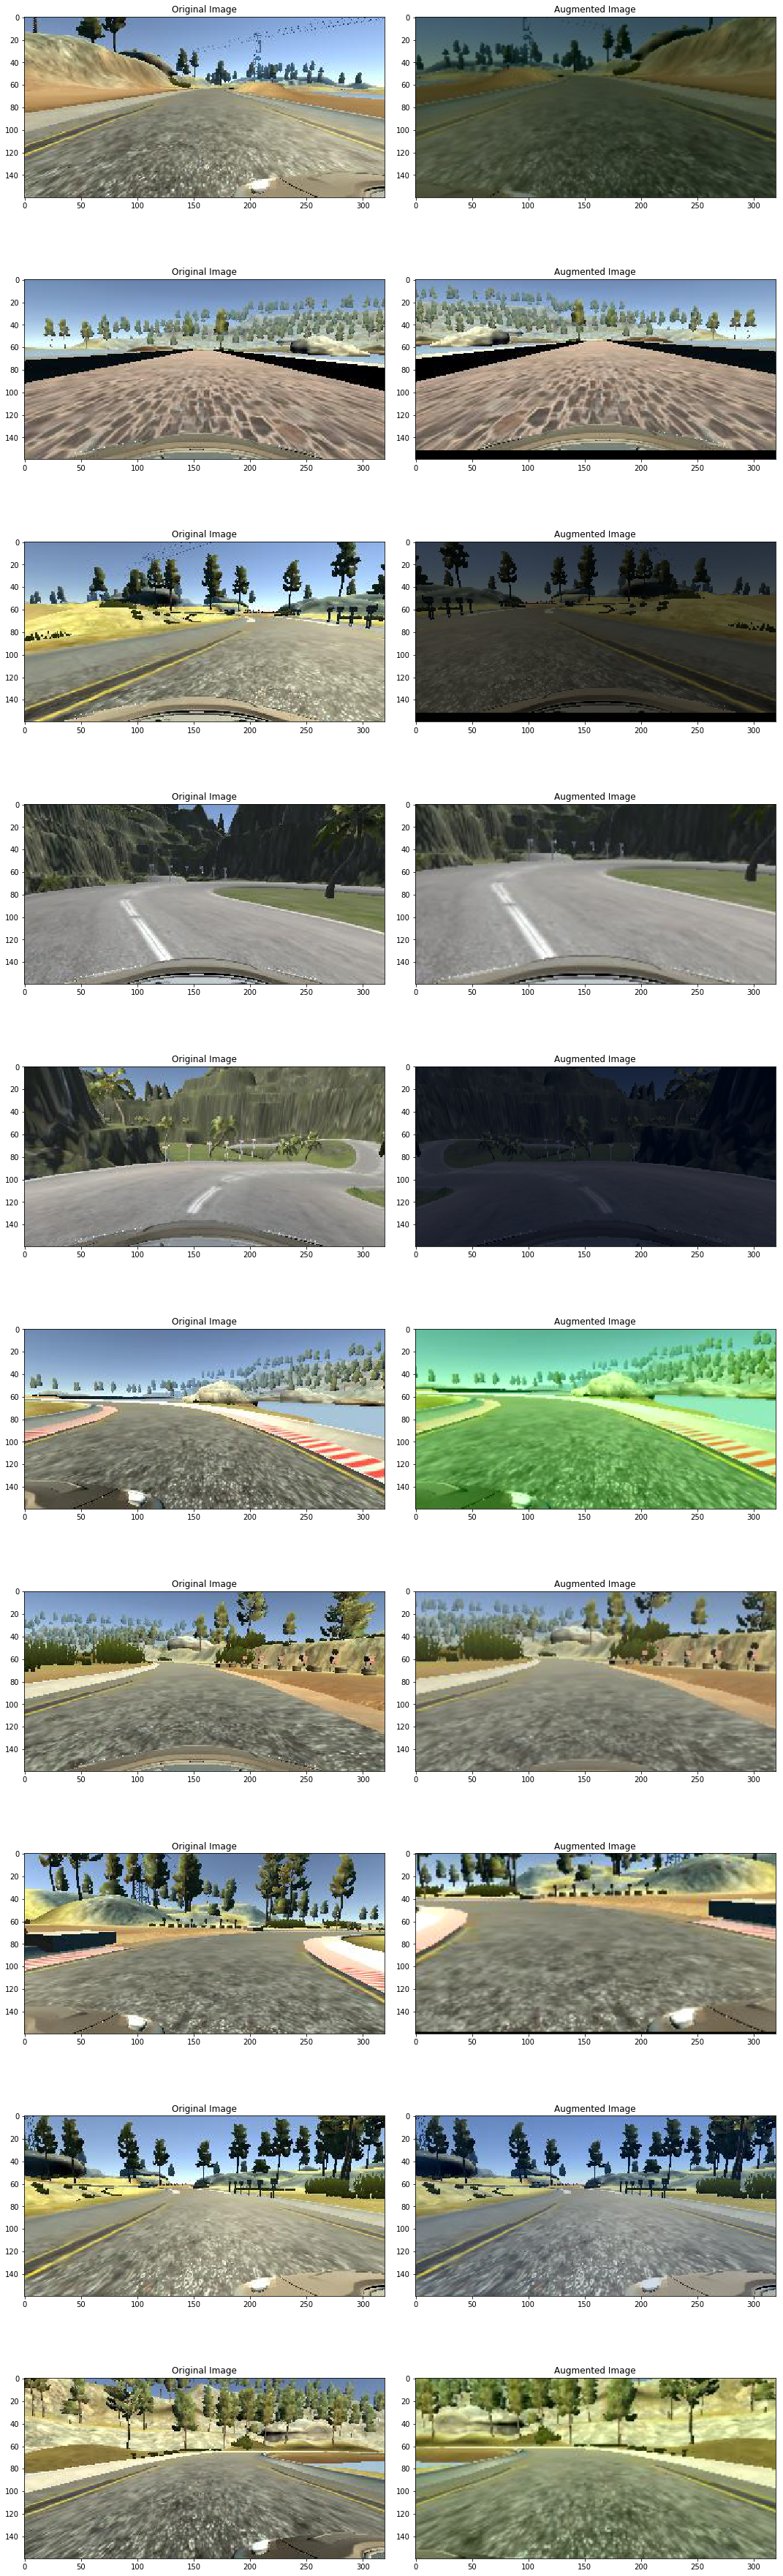

In [ ]:
#Plotting Zoom
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

#Plotting Pan
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

#Plotting Brightness
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')


#Plotting Contrast
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
contrast_altered_image = img_contrast(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(contrast_altered_image)
axs[1].set_title('Contrast altered image ')

#Plotting Channel Shift
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
channel_altered_image = img_channel_shift(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(channel_altered_image)
axs[1].set_title('Channel altered image ')

#Plotting Flip
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

#PLotting Random Augmentation
fig, axs = plt.subplots(10, 2, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]
    
    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)
    
    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")
  
    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

#Plotting Preprocessed
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')


### Custom Augmented Data Generator

In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
        random_index = random.randint(0, len(image_paths) - 1)
      
        if istraining:
            im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
        else:
            im = mpimg.imread(image_paths[random_index])
            steering = steering_ang[random_index]
      
        im = img_preprocess(im)
        batch_img.append(im)
        batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  

Text(0.5, 1.0, 'Validation Image')

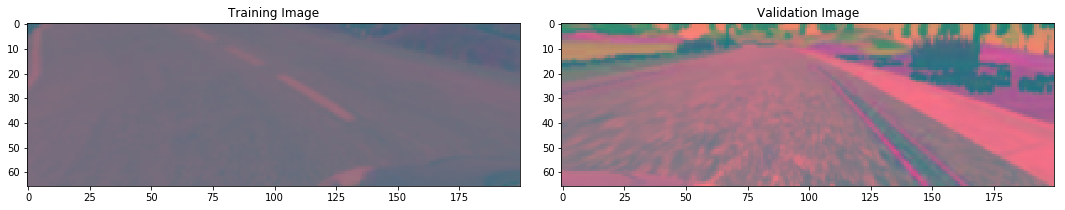

In [ ]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

### NN Model

In [ ]:
def nmodel():
    m = Sequential()
    #5 Conv Layers
    m.add(Convolution2D(24, kernel_size=(5,5), strides= (2,2), 
                        input_shape=(66,200,3), activation = 'relu'))
    m.add(Convolution2D(36, kernel_size=(5,5), strides= (2,2), activation = 'relu'))
    m.add(Convolution2D(48, kernel_size=(5,5), strides= (2,2), activation = 'relu'))
    m.add(Convolution2D(64, kernel_size=(3,3), activation = 'relu'))
    m.add(Convolution2D(64, kernel_size=(3,3), activation = 'relu'))

    m.add(Flatten())
    #4 Dense Layers
    m.add(Dense(100, activation = 'relu'))
    #m.add(Dropout(0.5))
    m.add(Dense(50, activation = 'relu'))
    #m.add(Dropout(0.5))
    m.add(Dense(10, activation = 'relu'))
    m.add(Dense(1))
    m.compile(optimizer = Adam(lr = 0.0001), loss = 'mean_squared_error')
    return m

In [ ]:
model = nmodel()
print(model.summary())

W0624 04:15:47.642438 140055395743616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0624 04:15:47.658363 140055395743616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0624 04:15:47.661618 140055395743616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0624 04:15:47.783501 140055395743616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               115300    
__________

### Training

In [ ]:
m = model.fit_generator(batch_generator(X_train, y_train, 150, 1),
                        steps_per_epoch=1000, 
                        epochs=20,
                        validation_data=batch_generator(X_valid, y_valid, 100, 0),
                        validation_steps=200,
                        shuffle = 1)

W0624 04:15:48.243982 140055395743616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0624 04:15:48.451061 140055395743616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/20
1000/1000 [==============================] - 565s 565ms/step - loss: 0.1030 - val_loss: 0.0688
Epoch 2/20
1000/1000 [==============================] - 554s 554ms/step - loss: 0.0831 - val_loss: 0.0642
Epoch 3/20
1000/1000 [==============================] - 554s 554ms/step - loss: 0.0767 - val_loss: 0.0578
Epoch 4/20
1000/1000 [==============================] - 553s 553ms/step - loss: 0.0717 - val_loss: 0.0573
Epoch 5/20
1000/1000 [==============================] - 548s 548ms/step - loss: 0.0673 - val_loss: 0.0547
Epoch 6/20
1000/1000 [==============================] - 561s 561ms/step - loss: 0.0641 - val_loss: 0.0510
Epoch 7/20
1000/1000 [==============================] - 563s 563ms/step - loss: 0.0612 - val_loss: 0.0483
Epoch 8/20
1000/1000 [==============================] - 562s 562ms/step - loss: 0.0588 - val_loss: 0.0458
Epoch 9/20
1000/1000 [==============================] - 562s 562ms/step - loss: 0.0559 - val_loss: 0.0452
Epoch 10/20
1000/1000 [=======================

Text(0.5, 0, 'Epoch')

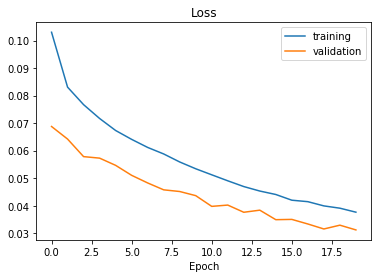

In [ ]:
plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

### Save model to test

In [ ]:
model.save('sdc.h5')

In [ ]:
from google.colab import files
files.download('sdc.h5')

E0624 07:24:13.287217 140055395743616 ultratb.py:152] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-ffa5d203fe75>", line 2, in <module>
    files.download('sdc.h5')
  File "/usr/local/lib/python3.6/dist-packages/google/colab/files.py", line 178, in download
    'name': _os.path.basename(filename),
  File "/usr/local/lib/python3.6/dist-packages/google/colab/output/_js.py", line 39, in eval_js
    return _message.read_reply_from_input(request_id)
  File "/usr/local/lib/python3.6/dist-packages/google/colab/_message.py", line 101, in read_reply_from_input
    time.sleep(0.025)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInter

KeyboardInterrupt: ignored

E0624 07:24:13.492775 140055395743616 zmqstream.py:435] Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 421, in execute_request
    self._abort_queues()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 637, in _abort_queues
    self._abort_queue(stream)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py",